## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Redes convolucionales


### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos las redes profundas convolucionales (CNN). Implementaremos nuestra propia red utilizando la biblioteca (API) Keras (https://keras.io/). 

Probaremos nuestros modelos más complejos de *deep learning* para la detección automática de frailejones sobre imagenes aereas del páramo e intentaremos mejorar los resultados que obtuvimos con nuestras redes más sencillas. Recordemos que hasta ahora hemos logrado unos resultados preliminares con un *accuracy* de validación de 0.86, utilizando una red sencilla de 5 neuronas. 

### Grupo

Lupe Pinzón, Camilo Angarita, Juan Andrés Cabal

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenesRGB import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from prettytable import PrettyTable
import datetime

import keras
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from numpy.random import seed
seed(1)

In [3]:
X,Y = import_imagenes_RGB()

print(X.shape, Y.shape, X[0,0,0])

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


**Salida esperada:**

(250, 70, 70, 3) (1, 250) [0.58823529 0.5372549  0.40392157]


## 1. Redes convolucionales

Las redes convolucionales (CNN: *Convolutional Neural Nets*) es un tipo de red neuronal (profunda) que suele usarse para el tratamiento de imagenes y la vision computacional, pero que también sirve para otras tareas como el procesamiento de datos secuenciales, lenguage natural, datos geo-referenciados o datos estructurados que guarden ciertas correlaciones entre sí (ver por ejemplo W. Kim (2014) Convolutional Neural Networks for Sentence Classification). 

Se les concoce por ser invariantes a translaciones, de tal manera que con su arquitectura producen exactamente la misma respuesta ante diferentes traslaciones (como por ejemplo rotaciones) que se le aplique a los datos de entrada. 

Un aspecto importante para entender las CNN de la mano con el tema que hemos visto hasta ahora en el curso, consiste en entender que los pesos y sesgos de una *capa convolucional* son **filtros** que extraen patrones particulares de los datos de entrada. Luego de la extracción de patrones, la red cuenta con capas densamente conectadas donde distintas neuronas pueden compartir el mismo filtro. 

Veamos:
https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

Entonces, las CNN se pueden entender como versiones regularizadas de las redes multi-capa *densamente conectadas* (donde cada neurona en una capa está conectada con todas las demás neuronas de la siguiente capa). Este tipo de conexión *densa* facilita el *sobre-ajuste* a los datos de muestra con los que se construyen los mdoelos. Así, las CNN se enfocan en construir patrones más complejos pero más simples, encontrando *areas* de atención en las que enfocarse, haciendo uso de filtros y de **convoluciones** (formalmente hablando, una convolución corresponde con la operación matemática de la correlación cruzada). 

Veamos un ejemplo con un filtro de $3\times 3$ y una *stride* de 1:


$$ Imagen = \begin{bmatrix}
    1  & 1  & 1 & 0 & 0\\
    0 & 1 & 1 & 1 & 0 \\
    0  & 0 & 1  & 1 & 1 \\
    0 & 0 & 1 & 1 & 0 \\
    0  & 1 & 1  & 0 & 0
\end{bmatrix};\;\;\; Filtro = \begin{bmatrix}
    1  & 0  & 1\\
    0  & 1 & 0 \\
    1  & 0 & 1 
\end{bmatrix}; \;\;\; Patron =\begin{bmatrix}
    4  & 3  & 4\\
    2  & 4 & 3 \\
    2  & 3 & 4 
\end{bmatrix}$$

Para obtener el nuevo patrón convolucionado, resolvemos la operación $\otimes_1$ denotando una convolución con un *stride* de 1, o una *ventana móvil de 1 en 1*, tal que $Patron = Imagen \otimes_1 Filtro$.



Además de la operación convolucional, tras una capa convolucional le suele seguir un filtro de agregación conocido como **pooling**. Este filtro también toma ventanas móviles y resume los valores dentro de su rango de acuerdo con una operación de agregación específica.

Por ejmplo, un *Max-pooling* consiste en tomar el máximo dentro de cada ventana. Si tomamos un filtro de Max-pooling de tamaño $2\times 2$ y un *stride* de 2, y lo aplicamos sbre el patrón $P$, obtenemos:

$$ P = \begin{bmatrix}
    5  & 4  & 6 & 3\\
    3  & 9 & 4 & 5 \\
    8  & 1 & 7  & 9  \\
    0 & 2 & 8 & 0  
\end{bmatrix}\;\;\; $$

$$ MaxPool_{2\times 2}^{stride=2}(P) = \begin{bmatrix}
    9  & 6\\
    8  & 9
\end{bmatrix}$$


La gran ventaja de las CNN es que aprenden de manera automática (sin necesidad de conocimiento previo) los filtros que de otro modo habría que especificar explícita o manualmente. 

Especifiquemos a continuación la arquitectura de nuestra CNN, donde vamos a hacer uso de una técnica de **Drop-out** antes de la capa de salida. Esta técnica elimina aleatoriamente y de manera temporal (en cada iteración) un número de neuronas determinado (por una tasa de eliminación o *drop-out*), con el fin de que el modelo no recaiga demasidado en ciertas neuronas y generalize de la mejor manera la función a estimar :

In [4]:
#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.2, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

### Optimizador de Adam

Vamos a implementar la red convolucional con la arquitectura especificada arriba haciendo uso del método de optimización estocástica de **Adam** (Kingma & Ba (2015)). El término *Adam* se debe a *Adaptive Moment Estimation*, y se puede entender como una revisión al método de RMSProp. Bajo Adam, se utilizan promedios móviles tanto de los gradientes como de sus segundos momentos.  De esta manera, se tiene que 

$$ u(\theta) = \rho_1 u(\theta_{viejo}) + (1-\rho_1) \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} }  $$

$$ v(\theta) = \rho_2 v(\theta_{viejo}) + (1-\rho_2) \biggr( \frac{\partial J (\hat \theta_{viejo}; x^{(i)}, y^{(i)})}{ \partial \hat \theta_{viejo} } \biggl)^2  $$

donde

$$ \hat u = \frac{u(\theta)}{1-\rho_1^t} $$

$$ \hat v = \frac{v(\theta)}{1-\rho_2^t} $$

De tal manera que la actualización de los parámetros se lleva a cabo mediante:

$$ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\hat u}{\sqrt{\hat v}+\varepsilon}$$ 

donde $\varepsilon$ es un escalar muy pequeño (infinitesimal) que previene la división por cero, $\rho_1, \rho_2$ son respectivamente  los factores de memoria sobre el primer y segundo momento de los gradientes. 

In [5]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN_initseed=1_part_seed='+str(r)+'.tf')
        model.save(pathr, overwrite=True) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelo_CNN_initseed=1_part_seed=3.tf/assets
Epoca= 13 , accu_v1=0.8918918967247009 , accu_v2=0.9210526347160339
Epoca= 59 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN_initseed=1_part_seed=1.tf/assets
Epoca= 96 , accu_v1=0.9189189076423645 , accu_v2=0.9473684430122375
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9829 | 0.8919 | 0.9211 |   13  |
|  1.0   | 0.8649 | 0.8684 |   59  |
|  0.96  | 0.9189 | 0.9474 |   96  |
+--------+--------+--------+-------+


### Pregunta 3.1

Qué puede observar sobre estos resultados?

Con base en los resultados es posible observar que el modelo hace casi una predicción completa sobre los datos de entrenamiento (en las tres repeticiones la exactitud es casi igual a 1), mientras que la exactitud de validación y prueba oscilan entre 0.81 y 0.94, siende este último la mejor predicción sobre el conjunto de datos de prueba. 

Visualicemos el aprendizaje del mejor modelo:

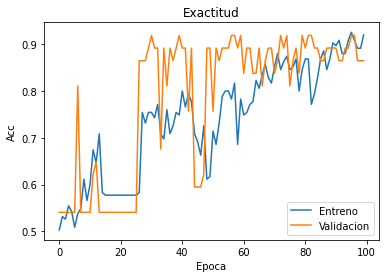

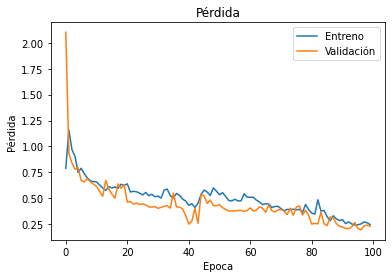

In [6]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Cargamos el mejor modelo y confirmamos el desempeño del modelo sobre todo el conjunto de datos:

In [7]:
# red convolucional
model_3 = load_model('modelo_CNN_initseed=1_part_seed=3.tf')

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

Veamos el desempeño del mejor modelo sobre todo el conjunto de datos:

In [8]:
Y_pred = model_3.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[135,  10],
       [  0, 105]])

**Salida esperada:**
    
<table style="width:20%">
    <tr>
       <td> 134 </td>
       <td> 11 </td>
    </tr>
    <tr>
       <td> 4 </td>
       <td> 101 </td>
    </tr>

</table>

### Ejercicio 1.1

Intente hacer que el optimizador Adam converja en todas las repeticiones. 


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8, decay = 2.5e-4)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 35 , accu_v1=0.837837815284729 , accu_v2=0.8684210777282715
Epoca= 32 , accu_v1=0.8108108043670654 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 51 , accu_v1=0.837837815284729 , accu_v2=0.9210526347160339
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8684 |   35  |
|  1.0   | 0.8108 | 0.8684 |   32  |
| 0.9943 | 0.8378 | 0.9211 |   51  |
+--------+--------+--------+-------+


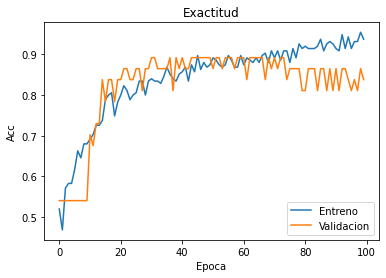

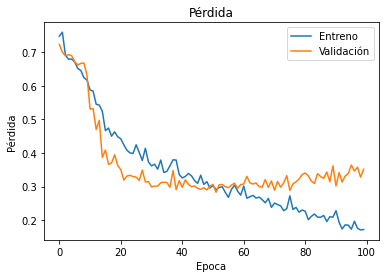

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Al cambiar los valores de beta_1 a 0.5, la tasa de aprendizaje a 0.0002, epsilon a 1e-8 y la tasa de de decaimiento a 0.00025 es posible observar que los resultados de las tres repetciciones son muy similares entre ellos, y la función de perdida de entrenamiento disminuye rapidamente a cero. Este resultado puede ser una mejoraría con respecto al resultado anterior, aunque es importante tener en cuenta que la perdida sobre la muestra de validación no está convergiendo, lo que puede significar que los parametros pueden ser optimizados de mejor manera.

### Ejercicio 1.2

Compare los resultados al utilizar otros algoritmos de aprendizaje como RMSprop o el mismo SGD


In [11]:
# RMSprop

# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del RMSProp
rmsprop = keras.optimizers.RMSprop(lr=0.00008, rho=0.9)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer = rmsprop, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 65 , accu_v1=0.7837837934494019 , accu_v2=0.7894737124443054
Epoca= 99 , accu_v1=0.9189189076423645 , accu_v2=0.7894737124443054
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 94 , accu_v1=0.8648648858070374 , accu_v2=0.9210526347160339
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.8857 | 0.7838 | 0.7895 |   65  |
| 0.9257 | 0.9189 | 0.7895 |   99  |
| 0.9086 | 0.8649 | 0.9211 |   94  |
+--------+--------+--------+-------+


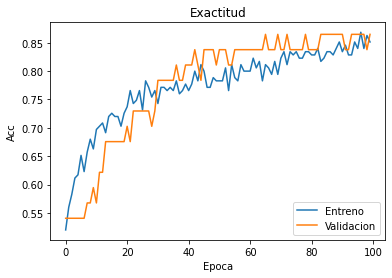

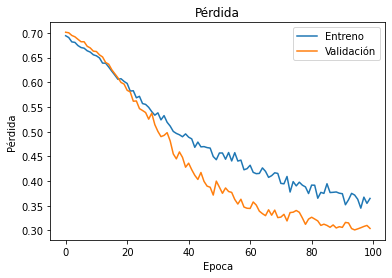

In [12]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [13]:
# red convolucional
model_4 = load_model('modelo_CNN1.tf')

model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [14]:
Y_pred = model_4.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[133,  12],
       [ 12,  93]])

In [15]:
# SGD

# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del SGD
sgd = keras.optimizers.SGD()

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer = sgd, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 87 , accu_v1=0.7567567825317383 , accu_v2=0.8421052694320679
Epoca= 99 , accu_v1=0.8648648858070374 , accu_v2=0.8157894611358643
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 94 , accu_v1=0.8108108043670654 , accu_v2=0.9210526347160339
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
| 0.9429 | 0.7568 | 0.8421 |   87  |
|  0.96  | 0.8649 | 0.8158 |   99  |
| 0.9371 | 0.8108 | 0.9211 |   94  |
+--------+--------+--------+-------+


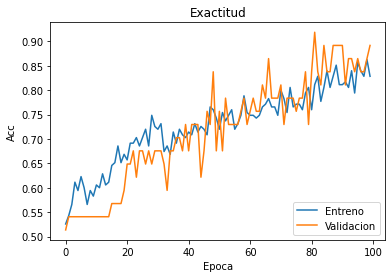

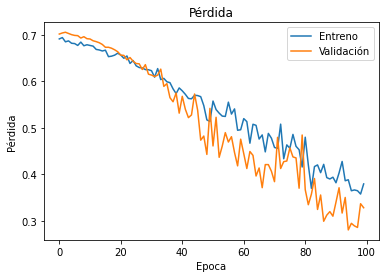

In [16]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [17]:
# red convolucional
model_5 = load_model('modelo_CNN1.tf')

model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [18]:
Y_pred = model_5.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [ 15,  90]])

Al mirar los resultados de los optimizadores RMSProp y SGD es posible observar que el de *Adam* es el que da el mejor resultado en terminos de predicción, ya que con este optimizador la predicción es del 96%, mientras que con los otros dos es del 90.4% y 90% respectivamente.

### Ejercicio 1.3

Compare los resultados con distintas tasas de *drop-out*.  

In [19]:
# Tasa de dropout igual a 0.25

#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.25, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [20]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr, overwrite=True) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 15 , accu_v1=0.8918918967247009 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN2.tf/assets
Epoca= 72 , accu_v1=0.837837815284729 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 41 , accu_v1=0.8108108043670654 , accu_v2=0.8947368264198303
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8919 | 0.8684 |   15  |
| 0.9886 | 0.8378 | 0.8684 |   72  |
|  1.0   | 0.8108 | 0.8947 |   41  |
+--------+--------+--------+-------+


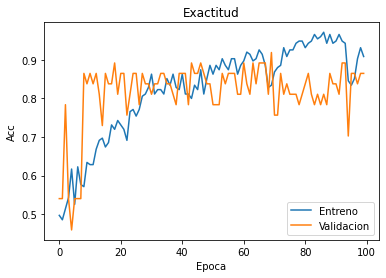

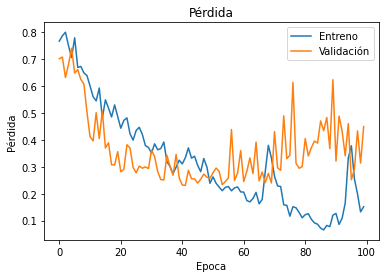

In [21]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [22]:
# red convolucional
model_6 = load_model('modelo_CNN3.tf')

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [23]:
Y_pred = model_6.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[139,   6],
       [  3, 102]])

Al cambiar la tasa de **dropout** de 0.2 a 0.25 el resultado del modelo mejora y pasa de 96% a 96.4%, una leve mejoraria con respecto al modelo inicial.


In [24]:
# Tasa de dropout igual a 0.3

#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.3, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [25]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr, overwrite=True) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 15 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN2.tf/assets
Epoca= 95 , accu_v1=0.8648648858070374 , accu_v2=0.8684210777282715
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 8 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8649 | 0.8684 |   15  |
| 0.9829 | 0.8649 | 0.8684 |   95  |
| 0.5771 | 0.5405 | 0.6316 |   8   |
+--------+--------+--------+-------+


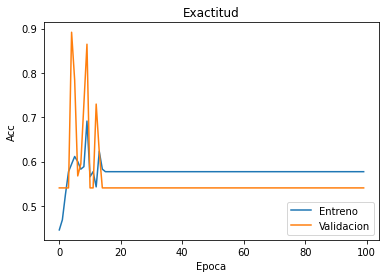

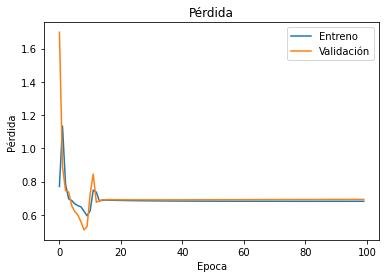

In [26]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [27]:
# red convolucional
model_7 = load_model('modelo_CNN3.tf')

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [28]:
Y_pred = model_7.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[138,   7],
       [  3, 102]])

Al cambiar la tasa de **dropout** de 0.2 a 0.3 el resultado del modelo cae y pasa de 96% a 95.6%, lo que signifca un leve desmejoramiento con respecto al modelo con un **dropout** igual a 0.2 y 0.3.

In [29]:
# Tasa de dropout igual a 0.35

#inicializacion Normal
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

# Inicializacion de He
initHe = keras.initializers.he_normal(seed=1)

# Arquitectura de la red
model = Sequential()  
model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3), activation='tanh', kernel_initializer=initnorm, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='selu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer=initHe, bias_initializer='zeros'))
model.add(Dropout(rate=0.35, seed=1))   
model.add(Dense(1, activation='sigmoid', kernel_initializer=initnorm, bias_initializer='zeros')) 
    
# Guardamos la arquitectura de red
config_cnn = model.get_config()

In [30]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Epoca"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=100

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

# implementamos 3 repeticiones con particiones distintas de entrenamiento y doble validacion
for i in range(0,3,1):
    r = i^3
    CE_x, CV0_x, CE_y, CV0_y = train_test_split(X, Y.T, test_size = 0.3, random_state = r)
    CV_x, CP_x, CV_y, CP_y = train_test_split(CV0_x, CV0_y, test_size = 0.5, random_state = r)
       
    # Definimos la arquitectura de la red
    model = Sequential.from_config(config_cnn)
    
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
    
    # Encontramos el mejor modelo en validación
    min_err=np.min(history.history['val_loss'])
    best_epoc=np.where(history.history['val_loss'] == min_err)[0] 
       
    # Conseguimos el mejor modelo de acuerdo con su desempeño en validación
    model.fit(x=CE_x, y=CE_y, epochs=best_epoc[0], validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
            
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=CP_x, y=CP_y, verbose=0)
    
    ## Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('modelo_CNN'+str(r)+'.tf')
        model.save(pathr, overwrite=True) 
        err_p = loss_p

    # Imprimimos el desempeño para cada repetición
    print('Epoca= '+str(best_epoc[0])+' , accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), best_epoc[0]])

print(x)

INFO:tensorflow:Assets written to: modelo_CNN3.tf/assets
Epoca= 20 , accu_v1=0.837837815284729 , accu_v2=0.8947368264198303
INFO:tensorflow:Assets written to: modelo_CNN2.tf/assets
Epoca= 73 , accu_v1=0.8918918967247009 , accu_v2=0.8421052694320679
INFO:tensorflow:Assets written to: modelo_CNN1.tf/assets
Epoca= 8 , accu_v1=0.5405405163764954 , accu_v2=0.6315789222717285
+--------+--------+--------+-------+
| Exac_E | Exac_V | Exac_P | Epoca |
+--------+--------+--------+-------+
|  1.0   | 0.8378 | 0.8947 |   20  |
| 0.9943 | 0.8919 | 0.8421 |   73  |
| 0.5771 | 0.5405 | 0.6316 |   8   |
+--------+--------+--------+-------+


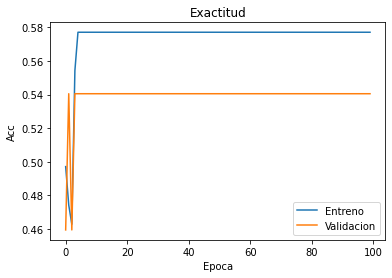

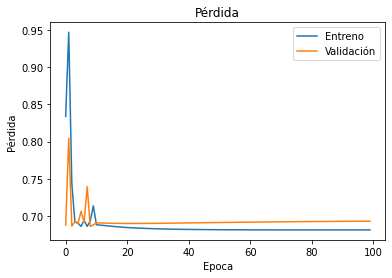

In [31]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [32]:
# red convolucional
model_8 = load_model('modelo_CNN3.tf')

model_8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)             

In [33]:
Y_pred = model_8.predict(X)
Y_preds = (Y_pred > 0.5)

confusion_matrix(Y.T, Y_preds)

array([[138,   7],
       [  3, 102]])

Al cambiar la tasa de dropout de 0.2 a 0.3 el resultado del modelo cae y pasa de 96% a 95.6%, lo que signifca un leve desmejoramiento con respecto al modelo con un dropout igual a 0.2 y 0.3.

### Bono

Visualice los distintos filtros convolucionales para entender qué tipo de patrones están aprendiendo que son relevantes para la detección de frailejones.

*A continuación se indica cómo visulizar una capa convolucional. Examine las distintas capas convolucionales y analice lo que puede visualizar.*

In [34]:
from matplotlib import pyplot

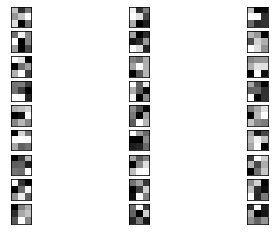

In [52]:

# cargamos los pesos de la primera capa escondida
filters, biases = model_6.layers[0].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 9, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

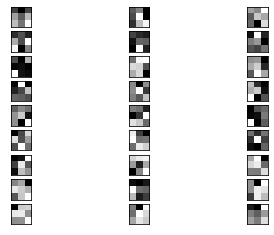

In [53]:
# cargamos los pesos de la segunda capa escondida
filters, biases = model_6.layers[2].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 9, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

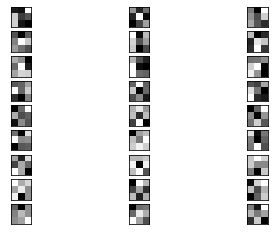

In [54]:
# cargamos los pesos de la tercera capa escondida
filters, biases = model_6.layers[4].get_weights()
# normalizamos los valores de los filtros (0,1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# graficamos los primeros filtros
n_filters, ix = 9, 1
for i in range(n_filters):
# tomamos los filtros
    f = filters[:, :, :, i]
# graficamos cada canal separadamente
    for j in range(3):
        # subplot y axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
# graficamos cada filtro en escala de grises
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# graficamos la figura
pyplot.show()

Al mirar los filtros de las distintas capas convolucionales es posible observar que la primera captura en cierto grado los matices claros de la imegen, la segunda capa los oscuros y, finalmente, la tercera capa parece mezclar un poco los colores entre blancos y negros. 

## 2. Caso aplicado

Ahora probemos nuestro modelo sobre la imagen completa de prueba del paramo ``IMG_3451.JPG``.


In [36]:
from keras.preprocessing import image

img = image.load_img('IMG_3451.JPG')

### Red Convolucional

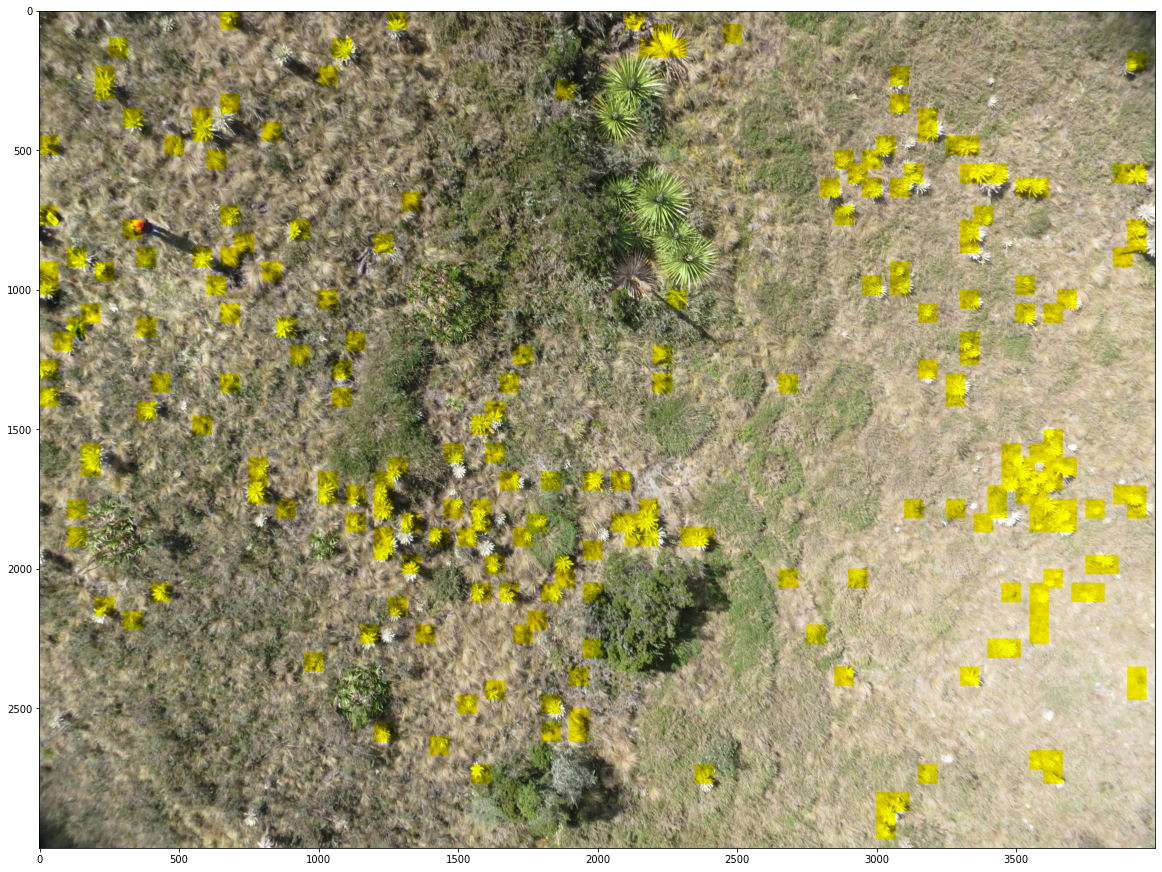

In [38]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]/255.
        subi2=np.expand_dims(subi,0)
        Y_preds = model_6.predict(subi2)
        pred_P = (Y_preds > 0.5)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)


Lectura avanzada sobre métodos de optimización en redes profundas: https://openreview.net/pdf?id=ryQu7f-RZ
http://www.cs.utoronto.ca/~ilya/pubs/2013/1051_2.pdf
        